This example is based off https://github.com/benmoseley/harmonic-oscillator-pinn 

In [1]:
# uncomment the following to install the required packages
# !pip install -r requirements.txt

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

np.random.seed(0)
torch.random.manual_seed(0)

plt.rcParams['font.size'] = 16
plt.rcParams['lines.markersize'] = 10


In this notebook, we will learn the dynamics of a 1D dampened harmonic oscillator with unit mass, spring constant $k$ and dampening constant $\mu$:
$$
\dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
from the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$

### 1. Exact solution and data
For the underdampened case,
$$
\mu^2 < 4 k~,~~~~~\text{with},
$$
the exact solution is given by 
$$
x(t) = e^{-\mu t/2}(\cos(\omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{k - \mu^2/4}~.
$$
In practice, we are given a data set that is the solution of a differntial equation. We make the *assumption* that the differential equation is of a known form (i.e., we know the physical equations).

 Let's turn the above exact solution into a function that we can use to generate a training data set $X_{\mathrm{train}}$ consisting of points $(t_i, x_i)$, where $t_i$ are evenly spaced times on some interval and $x_i=x(t_i)$ is given by the above exact solution. We wil also create a test data set $X_{\mathrm{test}}$ on a longer time interval. 

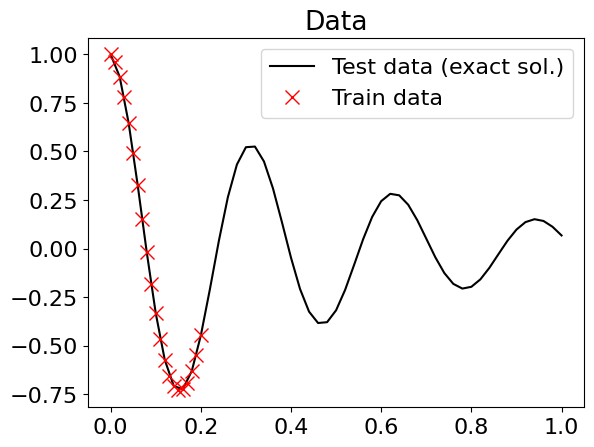

In [3]:
MU = 4
K = 400

N_TRAIN = 20
TMAX_TRAIN = 0.2

N_TEST = 50
TMAX_TEST = 1


def exact_solution(t, k=K, mu=MU):
    """Get exact solution to the 1D underdamped harmonic oscillator."""
    d = mu / 2
    w0 = k**0.5
    assert d < w0, "System must be underdamped."
    w = np.sqrt(w0**2 - d**2)
    x = torch.exp(-d * t) * torch.cos(w * t)
    return x


t_train = torch.linspace(0, TMAX_TRAIN, N_TRAIN + 1).reshape(-1, 1)
t_test = torch.linspace(0, TMAX_TEST, N_TEST + 1).reshape(-1, 1)

x_train = exact_solution(t_train)
x_test = exact_solution(t_test)

plt.plot(t_test, x_test, "k-", label="Test data (exact sol.)")
plt.plot(t_train, x_train, "rx", label="Train data")
plt.title("Data")
plt.legend()

### 2. Learning the dynamics with a ***basic neural network*** 
Now we will set up a neural network $x_\theta(t)$ to learn the dynamics $x(t)$ from the training data. We hope that it will generalise well to the test data, which is the exact solution over a longer time span. 

We do this by training the neural network on a loss function that minimises the mean squared error (MSE) between the predicted solution $x_{\theta}(t_i)$ and the observed (exact solution) values $(t_i, x_i)\in X_{\mathrm{train}}$. 

$$L_{\mathrm{data}} = \sum_{(t_i, x_i)\in X_{\mathrm{train}}}\|x_{\theta}(t_i) - x_i\|^2$$

loss = 0.40628668665885925
loss = 0.04303048178553581
loss = 0.00780273275449872
loss = 0.00014932437625247985
loss = 6.258768553379923e-05
loss = 2.4825170839903876e-05
loss = 1.3542266970034689e-05
loss = 1.2088038602087181e-05
loss = 8.21332105260808e-06
loss = 6.995670446485747e-06
loss = 6.174278041726211e-06
loss = 5.510064511327073e-06
loss = 4.957897999702254e-06
loss = 4.488633749133442e-06
loss = 4.085959062649636e-06
loss = 3.7547008560068207e-06
loss = 3.908779035555199e-06
loss = 1.938413697644137e-05
loss = 2.9470722893165657e-06
loss = 2.7474832222651457e-06


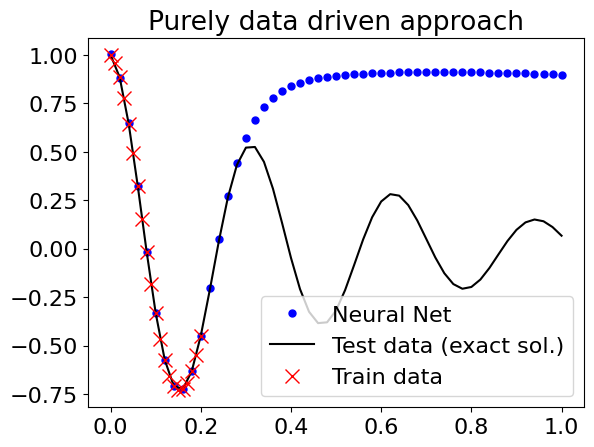

In [4]:
class NeuralNet(nn.Module):
    """Defines a pytorch neural network with one hidden layer."""

    def __init__(self, input_size=1, hidden_size=32, output_size=1):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        return self.network(x)


def train_nn(model, t_train, x_train):
    mse = nn.MSELoss()
    torch.manual_seed(123)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for i in range(10000):
        optimizer.zero_grad()

        # compute data loss
        x_pred = model(t_train)
        loss = mse(x_pred, x_train)

        # backward pass and update parameters
        loss.backward()
        optimizer.step()

        print(f"loss = {loss.item()}") if i % 500 == 0 else None


model_nn = NeuralNet()
train_nn(model_nn, t_train=t_train, x_train=x_train)

plt.plot(t_test, model_nn(t_test).detach().numpy(), 'b.', label='Neural Net')
plt.plot(t_test, x_test, 'k-', label='Test data (exact sol.)')
plt.plot(t_train, x_train, 'rx', label='Train data')
plt.title("Purely data driven approach")
plt.legend()

### 3. Learning the dynamics with a ***physics informed neural network***
Now we will train the physics informed neural network (PINN). This is done in exactly the same way as before, but we augment the loss function with the "physics loss".

$$L_{\mathrm{PINN}}=L_{\mathrm{data}} + L_{\mathrm{phys.}}$$
where
$$L_{\mathrm{phys.}} = \sum_{t_i\in X_{\mathrm{phys.}}}\|\ddot{x}_{\theta}(t_i)+ \mu\,\dot{x}_{\theta}(t_i) + k\,x_{\theta}(t_i)\|^2,$$
where $X_{\mathrm{phys.}}$ are a set of times, chosen by us, that we choose to evaluate the *physics loss* on 

In [5]:
# choose points to evaluate the physics loss with 
t_phys = np.random.uniform(0, 0.7, 50)

model_pinn = NeuralNet(1,32,1)
    
def train_pinn(model, t_train, x_train, t_phys):
    mse = nn.MSELoss()
    t_phys = torch.tensor(t_phys, requires_grad=True, dtype=torch.float32).reshape(-1,1)
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
    for i in range(10000):
        optimizer.zero_grad()
        
        # compute data loss
        x_pred = model(t_train)
        loss = mse(x_pred, x_train) 
        
        # compute physics loss
        x_phys = model(t_phys)
        xdot  = torch.autograd.grad(x_phys, t_phys, torch.ones_like(x_phys), create_graph=True)[0]# computes dx/dt
        xddot = torch.autograd.grad(xdot,  t_phys, torch.ones_like(xdot),  create_graph=True)[0]# computes d^2x/dt^2
        ode_residual = xddot + MU*xdot + K*x_phys 
        loss += (1e-4)*torch.mean(ode_residual**2)

        # backward pass and update params
        loss.backward()
        optimizer.step()
        print(f"loss = {loss.item()}") if i % 500 == 0 else None

train_pinn(model_pinn, t_train, x_train, t_phys)

loss = 0.9066201448440552
loss = 0.3826404809951782
loss = 0.3520295023918152
loss = 0.1129341572523117
loss = 0.0532337911427021
loss = 0.04545734450221062
loss = 0.0203230082988739
loss = 0.00813363678753376
loss = 0.003997507970780134
loss = 0.0024187639355659485
loss = 0.0015487385680899024
loss = 0.0010039942571893334
loss = 0.0006646511610597372
loss = 0.0004615307552739978
loss = 0.00032031588489189744
loss = 0.00023586653696838766
loss = 0.00018106798233930022
loss = 0.00014552666107192636
loss = 0.00012014991807518527
loss = 0.00010174822091357782


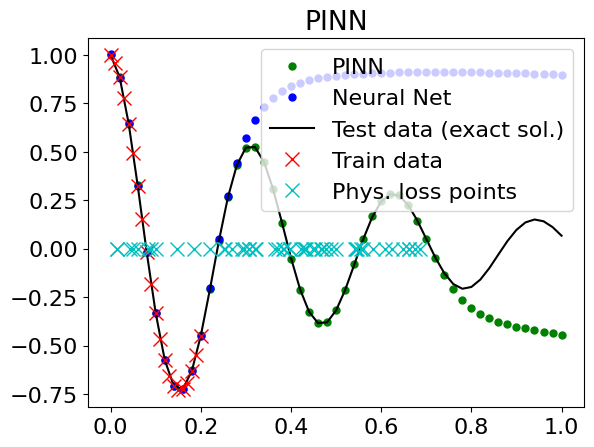

In [6]:
plt.plot(t_test, model_pinn(t_test).detach().numpy(), 'g.', label='PINN')
plt.plot(t_test, model_nn(t_test).detach().numpy(), 'b.', label='Neural Net')
plt.plot(t_test, x_test, 'k-', label='Test data (exact sol.)')
plt.plot(t_train, x_train, 'rx', label='Train data')
plt.plot(t_phys, 0*t_phys, 'cx', label='Phys. loss points')
plt.title("PINN")
plt.legend()